In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.metrics import accuracy_score, mean_absolute_error,mean_squared_error
    
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin, BaseEstimator

import keras
from keras import regularizers
from keras.layers import LSTM
from keras.layers import Input, Dense, LSTM, SimpleRNN, TimeDistributed
from keras.models import Model

from helpers import convert_3d_to_2d, reshape_to_batches, train_test_split_time_series

Using TensorFlow backend.


In [3]:
# Load data
data = pd.read_csv("data/all_data.csv",  parse_dates=['day'], index_col='day')
data.head(3)

,temperature_max,temperature_min,humidity,precip_intensity,precip_intensity_max,pressure,visibility,wind_speed,oil_price,lettuce_price,onion_price,tomato_price
day,,,,,,,,,,,,
2015-01-31 00:00:00+00:00,0.86,0.22,0.866429,2.21,2.45,101.42,450.37,0.55,31.509143,0.3320,0.3620,0.3900
2015-02-28 00:00:00+00:00,0.80,0.19,0.842143,0.01,0.02,101.66,559.40,0.42,33.266871,0.3325,0.3325,0.3325
2015-03-31 00:00:00+00:00,1.12,0.38,0.791875,0.00,0.02,102.05,487.51,0.49,31.995306,0.3225,0.7225,1.1600


In [4]:
#code for scaling, check the shape
pipeline = Pipeline([
    ('scaling', StandardScaler()),
])

X = pipeline.fit_transform(data.values)
print(X.shape)

(60, 12)


# Build the model

In [5]:
# index of the appropriate column
id_price = 11 
y = np.expand_dims(X[1:, id_price], -1)

#excluding the price feature from the data set entirely
X_ = X[0:-1, np.arange(X.shape[1]) != id_price]

print(X_.shape)
print(y.shape)

(59, 11)
(59, 1)


In [6]:
# Function to split dataset in train and test 
def train_test_split_time_series_regres(X, y, test_ratio=0.15):
    total_samples = X.shape[0]
    train_idx = int(total_samples * (1-test_ratio))
    XTrain = X[:train_idx]
    yTrain = y[:train_idx]
    XTest = X[train_idx:]
    yTest = y[train_idx:]
    return XTrain, yTrain, XTest, yTest

In [7]:
#apply the train test split
XTrain, yTrain, XTest, yTest = train_test_split_time_series_regres(X_, y)
print(XTrain.shape)
print(yTrain.shape)
print(XTest.shape)
print(yTest.shape)

(50, 11)
(50, 1)
(9, 11)
(9, 1)


In [10]:
#apply the reshape_to_batches with batch size of 30
BATCH_SIZE = 30
XTrain_batch = reshape_to_batches(XTrain, BATCH_SIZE)
yTrain_batch = reshape_to_batches(yTrain, BATCH_SIZE)
print(XTrain_batch.shape)
print(yTrain_batch.shape)

(2, 30, 11)
(2, 30, 1)


In [11]:
#reshape the test set
BATCH_SIZE = 30
XTest_batch = reshape_to_batches(XTest, BATCH_SIZE)
yTest_batch = reshape_to_batches(yTest, BATCH_SIZE)
print(XTest_batch.shape)
print(yTest_batch.shape)


(1, 30, 11)
(1, 30, 1)


In [12]:
from keras.layers import Input, Dense, LSTM, TimeDistributed
from keras.models import Model

In [13]:
inputs = Input(shape=(None, 11))

In [15]:
#model base
lstm = LSTM(64, activation='tanh', recurrent_activation='hard_sigmoid', use_bias=True, 
            kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal', 
            bias_initializer='zeros', unit_forget_bias=True, kernel_regularizer=None, 
            recurrent_regularizer=None, bias_regularizer=None, activity_regularizer=None, 
            kernel_constraint=None, recurrent_constraint=None, bias_constraint=None, dropout=0.0, 
            recurrent_dropout=0.0, implementation=1, return_sequences=True, return_state=False, 
            go_backwards=False, stateful=False, unroll=False)(inputs)

# the main difference with classification is that the activation of the last layer is linear
predictions = TimeDistributed(Dense(1, activation='linear'))(lstm)

lstm_model = Model(inputs=inputs, outputs=predictions)

# the second difference is the loss function (now MSE)
lstm_model.compile(optimizer='rmsprop',
                   loss='mean_squared_error',
                   metrics=['accuracy'])

lstm_model.fit(XTrain_batch, yTrain_batch, epochs=100)
#Predictions
y_pred_lstm = lstm_model.predict(XTest_batch)

Epoch 1/100
2/2 [==============================] - 5s 2s/step - loss: 0.8250 - acc: 0.1667
Epoch 2/100
2/2 [==============================] - 0s 48ms/step - loss: 0.7608 - acc: 0.1667
Epoch 3/100
2/2 [==============================] - 0s 44ms/step - loss: 0.7220 - acc: 0.1667
Epoch 4/100
2/2 [==============================] - 0s 42ms/step - loss: 0.6925 - acc: 0.1667
Epoch 5/100
2/2 [==============================] - 0s 55ms/step - loss: 0.6675 - acc: 0.1667
Epoch 6/100
2/2 [==============================] - 0s 55ms/step - loss: 0.6453 - acc: 0.1667
Epoch 7/100
2/2 [==============================] - 0s 42ms/step - loss: 0.6250 - acc: 0.1667
Epoch 8/100
2/2 [==============================] - 0s 46ms/step - loss: 0.6065 - acc: 0.1667
Epoch 9/100
2/2 [==============================] - 0s 48ms/step - loss: 0.5892 - acc: 0.1667
Epoch 10/100
2/2 [==============================] - 0s 46ms/step - loss: 0.5729 - acc: 0.1667
Epoch 11/100
2/2 [==============================] - 0s 53ms/step - loss

Epoch 89/100
2/2 [==============================] - 0s 55ms/step - loss: 0.1225 - acc: 0.1667
Epoch 90/100
2/2 [==============================] - 0s 60ms/step - loss: 0.1199 - acc: 0.1667
Epoch 91/100
2/2 [==============================] - 0s 38ms/step - loss: 0.1174 - acc: 0.1667
Epoch 92/100
2/2 [==============================] - 0s 46ms/step - loss: 0.1158 - acc: 0.1667
Epoch 93/100
2/2 [==============================] - 0s 45ms/step - loss: 0.1143 - acc: 0.1667
Epoch 94/100
2/2 [==============================] - 0s 45ms/step - loss: 0.1133 - acc: 0.1667
Epoch 95/100
2/2 [==============================] - 0s 56ms/step - loss: 0.1124 - acc: 0.1667
Epoch 96/100
2/2 [==============================] - 0s 53ms/step - loss: 0.1126 - acc: 0.1667
Epoch 97/100
2/2 [==============================] - 0s 41ms/step - loss: 0.1130 - acc: 0.1667
Epoch 98/100
2/2 [==============================] - 0s 39ms/step - loss: 0.1156 - acc: 0.1667
Epoch 99/100
2/2 [==============================] - 0s 40ms/

In [16]:
# Model LSTM 256
inputs = Input(shape=(None, 11))
lstm = LSTM(256, activation='tanh', recurrent_activation='hard_sigmoid', use_bias=True, 
            kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal', 
            bias_initializer='zeros', unit_forget_bias=True, kernel_regularizer=None, 
            recurrent_regularizer=None, bias_regularizer=None, activity_regularizer=None, 
            kernel_constraint=None, recurrent_constraint=None, bias_constraint=None, dropout=0.0, 
            recurrent_dropout=0.0, implementation=1, return_sequences=True, return_state=False, 
            go_backwards=False, stateful=False, unroll=False)(inputs)

predictions = TimeDistributed(Dense(1, activation='linear'))(lstm)
lstm_model256 = Model(inputs=inputs, outputs=predictions)
lstm_model256.compile(optimizer='rmsprop',
                      loss='mean_squared_error',
                      metrics=['accuracy'])
lstm_model256.fit(XTrain_batch, yTrain_batch, epochs=100)
# Prediction
y_pred_lstm256 = lstm_model256.predict(XTest_batch)

Epoch 1/100
2/2 [==============================] - 5s 2s/step - loss: 0.8293 - acc: 0.1667
Epoch 2/100
2/2 [==============================] - 0s 78ms/step - loss: 0.6921 - acc: 0.1667
Epoch 3/100
2/2 [==============================] - 0s 79ms/step - loss: 0.7896 - acc: 0.1333
Epoch 4/100
2/2 [==============================] - 0s 81ms/step - loss: 0.6282 - acc: 0.1667
Epoch 5/100
2/2 [==============================] - 0s 79ms/step - loss: 0.5822 - acc: 0.1667
Epoch 6/100
2/2 [==============================] - 0s 80ms/step - loss: 0.5546 - acc: 0.1667
Epoch 7/100
2/2 [==============================] - 0s 77ms/step - loss: 0.5304 - acc: 0.1667
Epoch 8/100
2/2 [==============================] - 0s 78ms/step - loss: 0.5077 - acc: 0.1667
Epoch 9/100
2/2 [==============================] - 0s 79ms/step - loss: 0.4855 - acc: 0.1667
Epoch 10/100
2/2 [==============================] - 0s 77ms/step - loss: 0.4632 - acc: 0.1667
Epoch 11/100
2/2 [==============================] - 0s 78ms/step - loss

Epoch 89/100
2/2 [==============================] - 0s 62ms/step - loss: 0.0840 - acc: 0.1667
Epoch 90/100
2/2 [==============================] - 0s 57ms/step - loss: 0.0813 - acc: 0.1667
Epoch 91/100
2/2 [==============================] - 0s 67ms/step - loss: 0.0772 - acc: 0.1667
Epoch 92/100
2/2 [==============================] - 0s 61ms/step - loss: 0.0927 - acc: 0.1667
Epoch 93/100
2/2 [==============================] - 0s 64ms/step - loss: 0.0848 - acc: 0.1667
Epoch 94/100
2/2 [==============================] - 0s 64ms/step - loss: 0.1019 - acc: 0.1667
Epoch 95/100
2/2 [==============================] - 0s 60ms/step - loss: 0.0813 - acc: 0.1667
Epoch 96/100
2/2 [==============================] - 0s 58ms/step - loss: 0.1010 - acc: 0.1667
Epoch 97/100
2/2 [==============================] - 0s 57ms/step - loss: 0.0840 - acc: 0.1667
Epoch 98/100
2/2 [==============================] - 0s 58ms/step - loss: 0.0739 - acc: 0.1667
Epoch 99/100
2/2 [==============================] - 0s 59ms/

In [14]:
# Model with : two layers, some dropout, some regularisation, more epochs

lstm = LSTM(64, activation='tanh', recurrent_activation='hard_sigmoid', use_bias=True, 
            kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal', 
            bias_initializer='zeros', unit_forget_bias=True, 
            # -- reg 
            kernel_regularizer=regularizers.l2(0.001), 
            recurrent_regularizer=regularizers.l2(0.001), 
            bias_regularizer=None, activity_regularizer=None, 
            kernel_constraint=None, recurrent_constraint=None, bias_constraint=None, 
            # -- dropout
            dropout=0.3, 
            recurrent_dropout=0.04, 
            implementation=1, return_sequences=True, return_state=False, 
            go_backwards=False, stateful=False, unroll=False)(inputs)

lstm1 = LSTM(64, activation='tanh', recurrent_activation='hard_sigmoid', use_bias=True, 
            kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal', 
            bias_initializer='zeros', unit_forget_bias=True, 
            # -- reg
            kernel_regularizer=regularizers.l2(0.001), 
            recurrent_regularizer=regularizers.l2(0.001), 
            bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, 
            recurrent_constraint=None, bias_constraint=None, 
            # -- dropout
            dropout=0.3, 
            recurrent_dropout=0.04, 
            implementation=1, return_sequences=True, return_state=False, 
            go_backwards=False, stateful=False, unroll=False)(lstm)

dense =  TimeDistributed(Dense(64, activation='sigmoid'))(lstm1)
predictions = TimeDistributed(Dense(1, activation='linear'))(dense)
model_lstm256x256r = Model(inputs=inputs, outputs=predictions)

model_lstm256x256r.compile(optimizer='rmsprop',
                           loss='mean_squared_error',
                           metrics=['accuracy'])
model_lstm256x256r.fit(XTrain_batch, yTrain_batch, epochs=500)



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/500





2/2 [==============================] - 12s 6s/step - loss: 1.6089 - acc: 0.0000e+00
Epoch 2/500
2/2 [==============================] - 0s 135ms/step - loss: 1.3723 - acc: 0.0000e+00
Epoch 3/500
2/2 [==============================] - 0s 86ms/step - loss: 1.2676 - acc: 0.0333
Epoch 4/500
2/2 [==============================] - 0s 99ms/step - loss: 1.2054 - acc: 0.0833
Epoch 5/500
2/2 [==============================] - 0s 95ms/step - loss: 1.1590 - acc: 0.1667
Epoch 6/500
2/2 [==============================] - 0s 104ms/step - loss: 1.0985 - acc: 0.1667
Epoch 7/500
2/2 [==============================] - 0s 95ms/step - loss: 1.0961 - acc: 0.1667
Epoch 8/500
2/2 [==============================] - 0s 103ms/step - loss: 1.0535 - acc: 0.1667
Epoch 9/500
2/2 [=========

2/2 [==============================] - 0s 87ms/step - loss: 0.7413 - acc: 0.1667
Epoch 56/500
2/2 [==============================] - 0s 86ms/step - loss: 0.7215 - acc: 0.1667
Epoch 57/500
2/2 [==============================] - 0s 83ms/step - loss: 0.7498 - acc: 0.1667
Epoch 58/500
2/2 [==============================] - 0s 98ms/step - loss: 0.7347 - acc: 0.1667
Epoch 59/500
2/2 [==============================] - 0s 81ms/step - loss: 0.7351 - acc: 0.1667
Epoch 60/500
2/2 [==============================] - 0s 83ms/step - loss: 0.6980 - acc: 0.1667
Epoch 61/500
2/2 [==============================] - 0s 90ms/step - loss: 0.7037 - acc: 0.1667
Epoch 62/500
2/2 [==============================] - 0s 89ms/step - loss: 0.7403 - acc: 0.1667
Epoch 63/500
2/2 [==============================] - 0s 85ms/step - loss: 0.7286 - acc: 0.1667
Epoch 64/500
2/2 [==============================] - 0s 91ms/step - loss: 0.6985 - acc: 0.1667
Epoch 65/500
2/2 [==============================] - 0s 119ms/step - loss:

Epoch 142/500
2/2 [==============================] - 0s 77ms/step - loss: 0.5027 - acc: 0.1667
Epoch 143/500
2/2 [==============================] - 0s 78ms/step - loss: 0.4926 - acc: 0.1667
Epoch 144/500
2/2 [==============================] - 0s 80ms/step - loss: 0.5183 - acc: 0.1667
Epoch 145/500
2/2 [==============================] - 0s 78ms/step - loss: 0.5056 - acc: 0.1667
Epoch 146/500
2/2 [==============================] - 0s 82ms/step - loss: 0.4634 - acc: 0.1667
Epoch 147/500
2/2 [==============================] - 0s 97ms/step - loss: 0.4501 - acc: 0.1667
Epoch 148/500
2/2 [==============================] - 0s 76ms/step - loss: 0.4122 - acc: 0.1667
Epoch 149/500
2/2 [==============================] - 0s 77ms/step - loss: 0.5108 - acc: 0.1667
Epoch 150/500
2/2 [==============================] - 0s 81ms/step - loss: 0.5456 - acc: 0.1667
Epoch 151/500
2/2 [==============================] - 0s 82ms/step - loss: 0.5607 - acc: 0.1667
Epoch 152/500
2/2 [==============================]

Epoch 229/500
2/2 [==============================] - 0s 83ms/step - loss: 0.3905 - acc: 0.1500
Epoch 230/500
2/2 [==============================] - 0s 82ms/step - loss: 0.3638 - acc: 0.1667
Epoch 231/500
2/2 [==============================] - 0s 88ms/step - loss: 0.3732 - acc: 0.1667
Epoch 232/500
2/2 [==============================] - 0s 82ms/step - loss: 0.3329 - acc: 0.1667
Epoch 233/500
2/2 [==============================] - 0s 147ms/step - loss: 0.5203 - acc: 0.1667
Epoch 234/500
2/2 [==============================] - 0s 79ms/step - loss: 0.4760 - acc: 0.1667
Epoch 235/500
2/2 [==============================] - 0s 80ms/step - loss: 0.3638 - acc: 0.1667
Epoch 236/500
2/2 [==============================] - 0s 77ms/step - loss: 0.3534 - acc: 0.1667
Epoch 237/500
2/2 [==============================] - 0s 88ms/step - loss: 0.3990 - acc: 0.1667
Epoch 238/500
2/2 [==============================] - 0s 96ms/step - loss: 0.4720 - acc: 0.1667
Epoch 239/500
2/2 [==============================

Epoch 315/500
2/2 [==============================] - 0s 103ms/step - loss: 0.3444 - acc: 0.1667
Epoch 316/500
2/2 [==============================] - 0s 87ms/step - loss: 0.3214 - acc: 0.1667
Epoch 317/500
2/2 [==============================] - 0s 93ms/step - loss: 0.3889 - acc: 0.1667
Epoch 318/500
2/2 [==============================] - 0s 86ms/step - loss: 0.3296 - acc: 0.1667
Epoch 319/500
2/2 [==============================] - 0s 80ms/step - loss: 0.3190 - acc: 0.1667
Epoch 320/500
2/2 [==============================] - 0s 84ms/step - loss: 0.3104 - acc: 0.1667
Epoch 321/500
2/2 [==============================] - 0s 81ms/step - loss: 0.3258 - acc: 0.1667
Epoch 322/500
2/2 [==============================] - 0s 82ms/step - loss: 0.3847 - acc: 0.1667
Epoch 323/500
2/2 [==============================] - 0s 84ms/step - loss: 0.3660 - acc: 0.1667
Epoch 324/500
2/2 [==============================] - 0s 81ms/step - loss: 0.2999 - acc: 0.1667
Epoch 325/500
2/2 [==============================

2/2 [==============================] - 0s 79ms/step - loss: 0.3213 - acc: 0.1667
Epoch 402/500
2/2 [==============================] - 0s 81ms/step - loss: 0.2683 - acc: 0.1667
Epoch 403/500
2/2 [==============================] - 0s 77ms/step - loss: 0.2649 - acc: 0.1667
Epoch 404/500
2/2 [==============================] - 0s 77ms/step - loss: 0.2827 - acc: 0.1667
Epoch 405/500
2/2 [==============================] - 0s 85ms/step - loss: 0.3155 - acc: 0.1667
Epoch 406/500
2/2 [==============================] - 0s 80ms/step - loss: 0.3201 - acc: 0.1667
Epoch 407/500
2/2 [==============================] - 0s 87ms/step - loss: 0.2750 - acc: 0.1500
Epoch 408/500
2/2 [==============================] - 0s 147ms/step - loss: 0.3089 - acc: 0.1667
Epoch 409/500
2/2 [==============================] - 0s 165ms/step - loss: 0.3108 - acc: 0.1667
Epoch 410/500
2/2 [==============================] - 0s 137ms/step - loss: 0.2776 - acc: 0.1667
Epoch 411/500
2/2 [==============================] - 0s 117ms

Epoch 487/500
2/2 [==============================] - 0s 87ms/step - loss: 0.2887 - acc: 0.1667
Epoch 488/500
2/2 [==============================] - 0s 86ms/step - loss: 0.2907 - acc: 0.1667
Epoch 489/500
2/2 [==============================] - 0s 88ms/step - loss: 0.2583 - acc: 0.1667
Epoch 490/500
2/2 [==============================] - 0s 96ms/step - loss: 0.2546 - acc: 0.1667
Epoch 491/500
2/2 [==============================] - 0s 81ms/step - loss: 0.3472 - acc: 0.1667
Epoch 492/500
2/2 [==============================] - 0s 87ms/step - loss: 0.2518 - acc: 0.1667
Epoch 493/500
2/2 [==============================] - 0s 87ms/step - loss: 0.2607 - acc: 0.1667
Epoch 494/500
2/2 [==============================] - 0s 84ms/step - loss: 0.3577 - acc: 0.1667
Epoch 495/500
2/2 [==============================] - 0s 84ms/step - loss: 0.2564 - acc: 0.1667
Epoch 496/500
2/2 [==============================] - 0s 86ms/step - loss: 0.2370 - acc: 0.1667
Epoch 497/500
2/2 [==============================]

# Evaluating the model

MAE LSTM 64:       0.93
MSE LSTM 64:       1.06
MAE LSTM 256:      0.88
MSE LSTM 256:      0.88
MAE LSTM 256x256r: 0.71
MSE LSTM 256x256r: 0.70


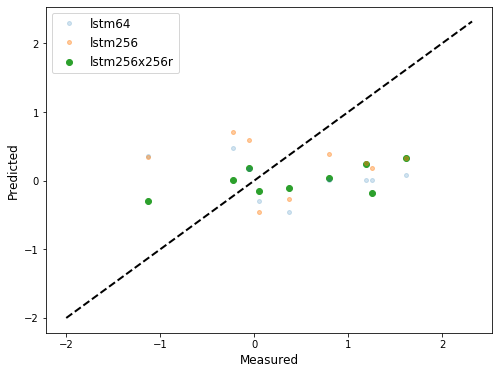

In [17]:
#com add your code here

y_pred_lstm256x256r = model_lstm256x256r.predict(XTest_batch)

print("MAE LSTM 64:       {0:.2f}".format(mean_absolute_error(yTest, convert_3d_to_2d(y_pred_lstm)[:9])))
print("MSE LSTM 64:       {0:.2f}".format(mean_squared_error(yTest, convert_3d_to_2d(y_pred_lstm)[:9])))
print("MAE LSTM 256:      {0:.2f}".format(mean_absolute_error(yTest, convert_3d_to_2d(y_pred_lstm256)[:9])))
print("MSE LSTM 256:      {0:.2f}".format(mean_squared_error(yTest, convert_3d_to_2d(y_pred_lstm256)[:9])))
print("MAE LSTM 256x256r: {0:.2f}".format(mean_absolute_error(yTest, convert_3d_to_2d(y_pred_lstm256x256r)[:9])))
print("MSE LSTM 256x256r: {0:.2f}".format(mean_squared_error(yTest, convert_3d_to_2d(y_pred_lstm256x256r)[:9])))

plt.figure(figsize=(8, 6))
plt.plot(yTest, convert_3d_to_2d(y_pred_lstm)[:9], color="C0", 
         ls="none", marker="o", markersize=4, alpha=0.2, label="lstm64")
plt.plot(yTest, convert_3d_to_2d(y_pred_lstm256)[:9], color="C1", 
         ls="none", marker="o", markersize=4, alpha=0.4, label="lstm256")
plt.scatter(yTest, convert_3d_to_2d(y_pred_lstm256x256r)[:9], label="lstm256x256r", color="C2")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Measured', fontsize=12)
plt.ylabel('Predicted', fontsize=12)
plt.legend(fontsize=12)

LSTM 256x256r has got less mean squared error and mean absolute error

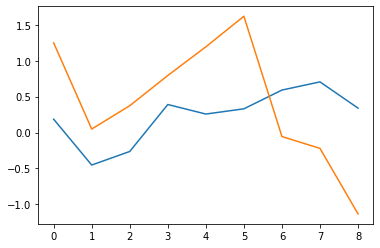

In [18]:
plt.plot(convert_3d_to_2d(y_pred_lstm256)[:9])
plt.plot(yTest)
plt.show()

Blue color: capture of the general trend, it learns with a fall

In [19]:
# To predict the future

y_shift = X[1:, :] # the "future"
X_shift = X[0:-1, :] # the "past"
print(X_shift.shape)
print(y_shift.shape)

(59, 12)
(59, 12)


In [20]:
# reshape to expected output
BATCH_SIZE = 30
X_batch = reshape_to_batches(X_shift, BATCH_SIZE)
y_batch = reshape_to_batches(y_shift, BATCH_SIZE)
print(X_batch.shape)
print(y_batch.shape)

(2, 30, 12)
(2, 30, 12)


In [21]:
#I use as a first layer a 512 LSTM without regularisation
inputs = Input(shape=(None, 12)) # This returns a tensor
lstm = LSTM(512, activation='tanh', recurrent_activation='hard_sigmoid', use_bias=True, 
            kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal', 
            bias_initializer='zeros', unit_forget_bias=True, kernel_regularizer=None, 
            recurrent_regularizer=None, bias_regularizer=None, activity_regularizer=None, 
            kernel_constraint=None, recurrent_constraint=None, bias_constraint=None, dropout=0.0, 
            recurrent_dropout=0.0, implementation=1, return_sequences=True, return_state=False, 
            go_backwards=False, stateful=False, unroll=False)(inputs)

In [22]:
predictions = TimeDistributed(Dense(12, activation='linear'))(lstm)
model_lstm512 = Model(inputs=inputs, outputs=predictions)

model_lstm512.compile(optimizer='rmsprop',
              loss='mean_squared_error',
              metrics=['accuracy'])

In [23]:
model_lstm512.fit(X_batch, y_batch, epochs=500)

Epoch 1/500
2/2 [==============================] - 6s 3s/step - loss: 0.9840 - acc: 0.1000
Epoch 2/500
2/2 [==============================] - 0s 147ms/step - loss: 0.7385 - acc: 0.1833
Epoch 3/500
2/2 [==============================] - 0s 142ms/step - loss: 0.6624 - acc: 0.2833
Epoch 4/500
2/2 [==============================] - 0s 150ms/step - loss: 0.5570 - acc: 0.2833
Epoch 5/500
2/2 [==============================] - 0s 140ms/step - loss: 0.5095 - acc: 0.3500
Epoch 6/500
2/2 [==============================] - 0s 179ms/step - loss: 0.4486 - acc: 0.3667
Epoch 7/500
2/2 [==============================] - 0s 181ms/step - loss: 0.4619 - acc: 0.4167
Epoch 8/500
2/2 [==============================] - 0s 163ms/step - loss: 0.4732 - acc: 0.3000
Epoch 9/500
2/2 [==============================] - 0s 134ms/step - loss: 0.4926 - acc: 0.3833
Epoch 10/500
2/2 [==============================] - 0s 137ms/step - loss: 0.4320 - acc: 0.3667
Epoch 11/500
2/2 [==============================] - 0s 192ms/s

Epoch 88/500
2/2 [==============================] - 0s 148ms/step - loss: 0.0870 - acc: 0.7500
Epoch 89/500
2/2 [==============================] - 0s 162ms/step - loss: 0.0885 - acc: 0.7333
Epoch 90/500
2/2 [==============================] - 0s 144ms/step - loss: 0.0972 - acc: 0.7333
Epoch 91/500
2/2 [==============================] - 0s 148ms/step - loss: 0.1025 - acc: 0.6833
Epoch 92/500
2/2 [==============================] - 0s 138ms/step - loss: 0.1155 - acc: 0.7833
Epoch 93/500
2/2 [==============================] - 0s 137ms/step - loss: 0.1077 - acc: 0.6500
Epoch 94/500
2/2 [==============================] - 0s 142ms/step - loss: 0.0954 - acc: 0.7833
Epoch 95/500
2/2 [==============================] - 0s 144ms/step - loss: 0.0717 - acc: 0.7333
Epoch 96/500
2/2 [==============================] - 0s 150ms/step - loss: 0.0672 - acc: 0.7667
Epoch 97/500
2/2 [==============================] - 0s 129ms/step - loss: 0.0630 - acc: 0.7667
Epoch 98/500
2/2 [==============================] 

Epoch 174/500
2/2 [==============================] - 0s 165ms/step - loss: 0.0376 - acc: 0.8667
Epoch 175/500
2/2 [==============================] - 0s 176ms/step - loss: 0.0361 - acc: 0.7833
Epoch 176/500
2/2 [==============================] - 0s 141ms/step - loss: 0.0365 - acc: 0.8667
Epoch 177/500
2/2 [==============================] - 0s 168ms/step - loss: 0.0281 - acc: 0.8167
Epoch 178/500
2/2 [==============================] - 0s 132ms/step - loss: 0.0248 - acc: 0.8667
Epoch 179/500
2/2 [==============================] - 0s 122ms/step - loss: 0.0214 - acc: 0.8333
Epoch 180/500
2/2 [==============================] - 0s 160ms/step - loss: 0.0215 - acc: 0.8833
Epoch 181/500
2/2 [==============================] - 0s 156ms/step - loss: 0.0219 - acc: 0.8500
Epoch 182/500
2/2 [==============================] - 0s 136ms/step - loss: 0.0238 - acc: 0.8333
Epoch 183/500
2/2 [==============================] - 0s 176ms/step - loss: 0.0244 - acc: 0.8333
Epoch 184/500
2/2 [=====================

Epoch 260/500
2/2 [==============================] - 0s 125ms/step - loss: 0.0137 - acc: 0.8667
Epoch 261/500
2/2 [==============================] - 0s 143ms/step - loss: 0.0123 - acc: 0.9167
Epoch 262/500
2/2 [==============================] - 0s 134ms/step - loss: 0.0115 - acc: 0.8667
Epoch 263/500
2/2 [==============================] - 0s 136ms/step - loss: 0.0101 - acc: 0.9000
Epoch 264/500
2/2 [==============================] - 0s 157ms/step - loss: 0.0106 - acc: 0.8500
Epoch 265/500
2/2 [==============================] - 0s 127ms/step - loss: 0.0117 - acc: 0.8833
Epoch 266/500
2/2 [==============================] - 0s 152ms/step - loss: 0.0141 - acc: 0.8833
Epoch 267/500
2/2 [==============================] - 0s 124ms/step - loss: 0.0134 - acc: 0.8833
Epoch 268/500
2/2 [==============================] - 0s 142ms/step - loss: 0.0140 - acc: 0.8833
Epoch 269/500
2/2 [==============================] - 0s 136ms/step - loss: 0.0115 - acc: 0.9167
Epoch 270/500
2/2 [=====================

Epoch 346/500
2/2 [==============================] - 0s 138ms/step - loss: 0.0059 - acc: 0.9333
Epoch 347/500
2/2 [==============================] - 0s 199ms/step - loss: 0.0061 - acc: 0.9333
Epoch 348/500
2/2 [==============================] - 0s 135ms/step - loss: 0.0056 - acc: 0.9333
Epoch 349/500
2/2 [==============================] - 0s 124ms/step - loss: 0.0064 - acc: 0.8667
Epoch 350/500
2/2 [==============================] - 0s 145ms/step - loss: 0.0069 - acc: 0.8833
Epoch 351/500
2/2 [==============================] - 0s 126ms/step - loss: 0.0079 - acc: 0.9167
Epoch 352/500
2/2 [==============================] - 0s 131ms/step - loss: 0.0080 - acc: 0.8667
Epoch 353/500
2/2 [==============================] - 0s 119ms/step - loss: 0.0076 - acc: 0.9000
Epoch 354/500
2/2 [==============================] - 0s 168ms/step - loss: 0.0065 - acc: 0.9167
Epoch 355/500
2/2 [==============================] - 0s 130ms/step - loss: 0.0059 - acc: 0.8833
Epoch 356/500
2/2 [=====================

Epoch 432/500
2/2 [==============================] - 0s 124ms/step - loss: 0.0043 - acc: 0.9500
Epoch 433/500
2/2 [==============================] - 0s 131ms/step - loss: 0.0045 - acc: 0.9500
Epoch 434/500
2/2 [==============================] - 0s 138ms/step - loss: 0.0039 - acc: 0.9333
Epoch 435/500
2/2 [==============================] - 0s 129ms/step - loss: 0.0040 - acc: 0.9500
Epoch 436/500
2/2 [==============================] - 0s 123ms/step - loss: 0.0039 - acc: 0.9167
Epoch 437/500
2/2 [==============================] - 0s 129ms/step - loss: 0.0044 - acc: 0.9667
Epoch 438/500
2/2 [==============================] - 0s 124ms/step - loss: 0.0047 - acc: 0.9167
Epoch 439/500
2/2 [==============================] - 0s 126ms/step - loss: 0.0052 - acc: 0.9667
Epoch 440/500
2/2 [==============================] - 0s 126ms/step - loss: 0.0051 - acc: 0.9333
Epoch 441/500
2/2 [==============================] - 0s 130ms/step - loss: 0.0053 - acc: 0.9667
Epoch 442/500
2/2 [=====================

In [33]:
#I left out the last X sample, we can start from there
days = 3*30

X_last = X[:, :]
X_batch = np.swapaxes(np.swapaxes(np.expand_dims(X_last, -1), 0, 2), 1, 2)


for i in range(days):
    #print("Day #{} - {} data points".format(i,X_batch.shape[1]))
    y_pred = model_lstm512.predict(X_batch)
    y_pred = np.swapaxes(np.expand_dims(np.expand_dims(y_pred[0,X_batch.shape[1]-1,:], -1), -1), 0, 2)
    X_batch = np.concatenate([X_batch,y_pred], axis=1)

In [28]:
df = pd.DataFrame(
        pipeline.inverse_transform(
                X_batch.reshape(X_batch.shape[1], X_batch.shape[2])))
df.iloc[:,0] = pd.to_datetime(df.iloc[:, 0], unit='s')


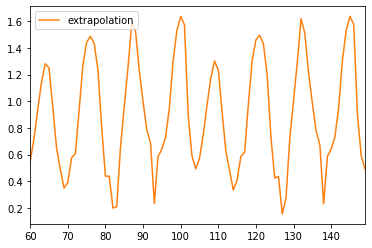

In [29]:
#plot just the prediction time series
df.iloc[-90:,1].plot(label='extrapolation', color='C1')
plt.legend()
plt.show()

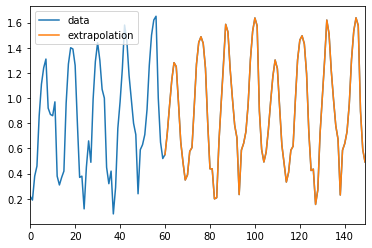

In [30]:
df.iloc[:,1].plot(label='data')
df.iloc[-90:,1].plot(label='extrapolation')
plt.legend()
plt.show()